In [1]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1


In [3]:
headers = []
datas = []
for run in range(8, 24):
    header = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation = header
    headers.append(header)

    data = np.loadtxt(f'../data/position/run{run}.tsv', delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append((V_in_combined, I_out_combined, I_out_std_combined))

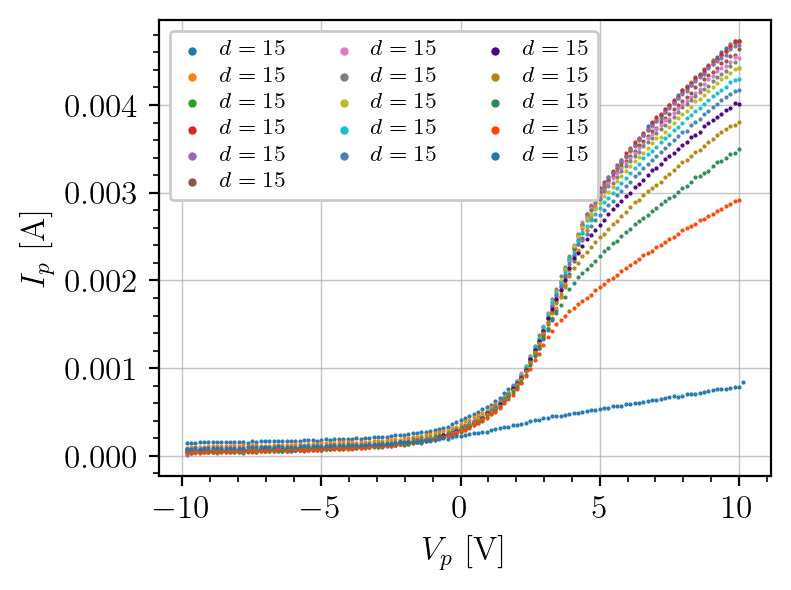

In [4]:
fig, ax = plt.subplots(1,1, dpi=200)
colors = list(plt.cm.tab10(np.arange(10))) + ["steelblue", "indigo", "darkgoldenrod", "seagreen", "orangered"]
ax.set_prop_cycle('color', colors)
plt.xlabel("$V_p$ [V]")
plt.ylabel("$I_p$ [A]")
for header, data in zip(headers, datas):
    p, d, G, A, f, I_chauffage, V_polarisation = header
    V_in, I_out, I_out_std = data

    plt.scatter(V_in, (I_out), label=f"$d = {run - 8}$")
    idx = I_out < 0
    # plt.scatter(V_in[idx], I_out[idx])
    plt.legend(ncols=3, fontsize=8, markerscale=4)

## Find V_{sp}, ln(I_{es})

In [5]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

In [34]:
T_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
T = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
n_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
for i, (header, data) in enumerate(zip(headers, datas)):
    p, d, G, A, f, I_chauffage, V_polarisation = header
    V_in, I_out, I_out_std = data

    dydx = np.gradient(np.log(I_out), V_in)
    threshold = 7e-2
    idx = np.abs(np.diff(dydx, prepend=0)) < threshold
    idx = np.logical_and(idx, V_in > 0)
    idx_B = set_all_between(np.logical_and(idx, V_in < 3.5))
    idx_C = set_all_between(np.logical_and(idx, V_in > 7))
    # idx_B = np.logical_and(0 < V_in, V_in < 3)
    # idx_C = V_in > 6

    coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
    coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
    fitfuncB = np.poly1d(coefsB)
    coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
    coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
    fitfuncC = np.poly1d(coefsC)

    x = np.linspace(V_in[0], V_in[-1])
    plt.scatter(V_in, np.log(I_out), c='k')
    plt.plot(x, fitfuncB(x))
    plt.plot(x, fitfuncC(x))

    V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
    I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
    print(V_sp, I_sp)
    plt.axvline(V_sp.n)
    plt.axhline(umath.log(I_sp).n)

    T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
    T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
    # TODO: verifier unitées
    n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
    print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
    T_e[i] = T_e_run
    T[i] = T_run
    n_e[i] = n_e_run

    plt.gcf().delaxes(plt.gca())

5.27+/-0.12 0.00341+/-0.00007
T_e_run = (2.80±0.05)×10⁴, T_run = (2.41±0.04)×10⁰, n_e_run = (2.60±0.05)×10¹⁶
4.87+/-0.08 0.00330+/-0.00005
T_e_run = (2.44±0.03)×10⁴, T_run = (2.10±0.03)×10⁰, n_e_run = (2.70±0.04)×10¹⁶
4.74+/-0.08 0.00326+/-0.00004
T_e_run = (2.34±0.03)×10⁴, T_run = (2.02±0.02)×10⁰, n_e_run = (2.72±0.03)×10¹⁶
4.67+/-0.07 0.00328+/-0.00004
T_e_run = (2.25±0.02)×10⁴, T_run = (1.94±0.02)×10⁰, n_e_run = (2.79±0.03)×10¹⁶
4.57+/-0.07 0.00322+/-0.00006
T_e_run = (2.22±0.02)×10⁴, T_run = (1.92±0.02)×10⁰, n_e_run = (2.76±0.05)×10¹⁶
4.49+/-0.07 0.00315+/-0.00004
T_e_run = (2.20±0.02)×10⁴, T_run = (1.90±0.02)×10⁰, n_e_run = (2.71±0.03)×10¹⁶
4.40+/-0.06 0.00312+/-0.00005
T_e_run = (2.15±0.02)×10⁴, T_run = (1.86±0.02)×10⁰, n_e_run = (2.72±0.04)×10¹⁶
4.32+/-0.06 0.00305+/-0.00004
T_e_run = (2.14±0.02)×10⁴, T_run = (1.85±0.02)×10⁰, n_e_run = (2.66±0.03)×10¹⁶
4.31+/-0.06 0.00301+/-0.00004
T_e_run = (2.14±0.02)×10⁴, T_run = (1.84±0.02)×10⁰, n_e_run = (2.62±0.04)×10¹⁶
4.24+/-0.06 0.00293

<Figure size 513.5x384.8 with 0 Axes>

In [53]:
distances = list(map(lambda header: header[1], headers))

Text(0, 0.5, '$T_e$ [K]')

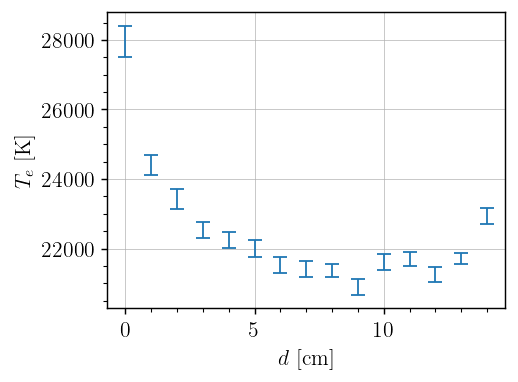

In [54]:
plt.errorbar(distances[:-1], nom_vals(T_e)[:-1], yerr=std_devs(T_e)[:-1], ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$T_e$ [K]')

Text(0, 0.5, '$k_B T_e$ [eV]')

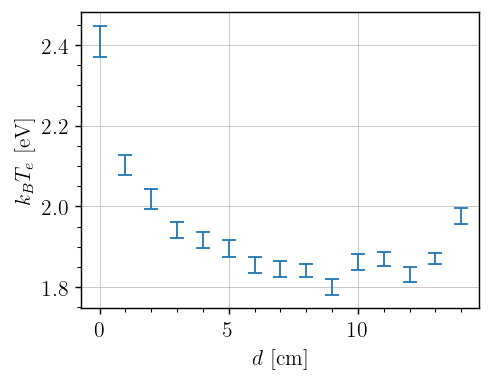

In [55]:
plt.errorbar(distances[:-1], nom_vals(T)[:-1], yerr=std_devs(T)[:-1], ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$k_B T_e$ [eV]')

Text(0, 0.5, '$n_e$ [1/m³]')

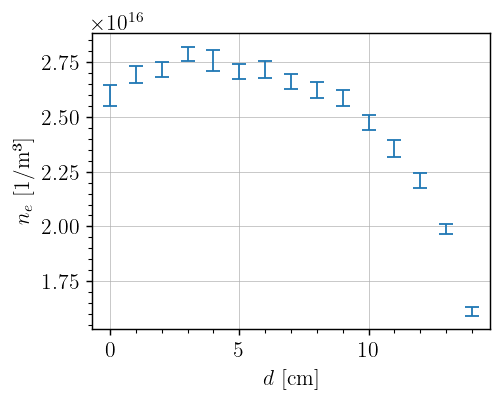

In [56]:
plt.errorbar(distances[:-1], nom_vals(n_e)[:-1], yerr=std_devs(n_e)[:-1], ls='')
plt.xlabel(r'$d$ [cm]')
plt.ylabel(r'$n_e$ [1/m³]')